In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !mkdir /kaggle/working/aerialimage

In [3]:
# create a folders to move train and validation files

# !mkdir /kaggle/working/aerialimage/train_input
# !mkdir /kaggle/working/aerialimage/train_target

# !mkdir /kaggle/working/aerialimage/val_input
# !mkdir /kaggle/working/aerialimage/val_target

In [4]:
# # create a folders to move train and validation files

# !mkdir /kaggle/working/aerialimage/train_input/input_data
# !mkdir /kaggle/working/aerialimage/train_target/target_data

# !mkdir /kaggle/working/aerialimage/val_input/input_data
# !mkdir /kaggle/working/aerialimage/val_target/target_data

In [1]:
import os
import glob

# from osgeo import gdal
import rasterio
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

from PIL import Image

In [2]:
# Check if TensorFlow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print(f"GPU Device Name: {device.name}")
else:
    print("No GPU devices found. Make sure TensorFlow GPU is properly installed.")

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

GPU Device Name: /physical_device:GPU:0
GPU Device Name: /physical_device:GPU:1
TensorFlow Version: 2.10.0


In [3]:
os.environ["PYTHONHASHSEED"] = str(23)
np.random.seed(23)
tf.random.set_seed(23)

In [4]:
# move input images to the folder

org_train_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/images/'
new_train_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_input/input_data'
new_val_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_input/input_data'

input_img_paths = []

for dirname, _, filenames in os.walk(org_train_input):
    for filename in filenames:
        input_img_paths.append(os.path.join(dirname, filename))

input_img_paths = sorted(input_img_paths)

random.Random(23).shuffle(input_img_paths)
    
input_img_paths[0:2]


['/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/images/chicago5.tif',
 '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/images/kitsap13.tif']

In [18]:
# shutil.rmtree('/kaggle/working/aerialimage')

In [13]:
# copy 18 input images to validation folder

val_num = 18

for file in input_img_paths[:val_num]:
    shutil.copy(file, new_val_input)
    
for file in input_img_paths[val_num:]:
    shutil.copy(file, new_train_input)
    
# for file in input_img_paths[:val_num]:
#     shutil.copy(file, new_val_input)
    
# for file in input_img_paths:
#     shutil.copy(file, new_train_input)

In [14]:
# move target images to the folder

org_train_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/gt/'
new_train_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_target/target_data'
new_val_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_target/target_data'

target_img_paths = []

for dirname, _, filenames in os.walk(org_train_target):
    for filename in filenames:
        target_img_paths.append(os.path.join(dirname, filename))

target_img_paths = sorted(target_img_paths)

random.Random(23).shuffle(target_img_paths)

target_img_paths[0:2]

['/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/gt/chicago5.tif',
 '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/gt/kitsap13.tif']

In [15]:
# copy 18 input images to validation folder

val_num = 18

for file in target_img_paths[:val_num]:
    shutil.copy(file, new_val_target)
    
for file in target_img_paths[val_num:]:
    shutil.copy(file, new_train_target)

# for file in target_img_paths[:val_num]:
#     shutil.copy(file, new_val_target)
    
# for file in target_img_paths:
#     shutil.copy(file, new_train_target)

In [16]:
# check whether folder names in input and target folders match

new_train_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_target/target_data'
new_val_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_target/target_data'

new_train_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_input/input_data'
new_val_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_input/input_data'

i = 0

for dirname, _, filenames in os.walk(new_train_input):
    for filename in filenames:
        print(filename)
        i += 1
        if i == 5:
            break
        

k = 0

for dirname, _, filenames in os.walk(new_train_target):
    for filename in filenames:
        print(filename)
        k += 1
        if k == 5:
            break

vienna34.tif
chicago2.tif
kitsap36.tif
kitsap31.tif
tyrol-w21.tif
vienna34.tif
chicago2.tif
kitsap36.tif
kitsap31.tif
tyrol-w21.tif


In [26]:
# create an image generator / data augmentation pipeline 
# augment data in train dataset only

BATCH_SIZE = 5
TARGET_SIZE = (512,512)
seed = 23

train_datagen = ImageDataGenerator(
                                   samplewise_std_normalization=False, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, # 1st run : False, 2nd run: True
                                   height_shift_range = 0.1, 
                                   width_shift_range = 0.1, 
                                   rotation_range = 3, # 1st run : 3, 2nd run:10
                                   shear_range = 0.01, # 1st run : 0.01, 2nd run: 0.1
                                   fill_mode = 'nearest',
                                   zoom_range = 0.05, #1st run 0.05, 2nd run: 0.1
                                   zca_whitening = True,
                                   zca_epsilon=1e-5, 
                                   )


target_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_std_normalization=False, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, # 1st run : False, 2nd run: True
                                   height_shift_range = 0.1, 
                                   width_shift_range = 0.1, 
                                   rotation_range = 3, # 1st run : 3, 2nd run:10
                                   shear_range = 0.01, # 1st run : 0.01, 2nd run: 0.1
                                   fill_mode = 'nearest',
                                   zoom_range = 0.05, #1st run 0.05, 2nd run: 0.1
                                   zca_whitening = True,
                                   zca_epsilon=1e-5, 
                                   )

val_input_datagen = ImageDataGenerator()

val_target_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
# use data augmentation pipeline and start loading train data from folders
TARGET_SIZE = (512,512)

train_generator_input = train_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_input',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed = seed

)

train_generator_output = target_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_target',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode="grayscale",
    seed = seed
)

train_generator = zip(train_generator_input, train_generator_output)

Found 162 images belonging to 1 classes.
Found 162 images belonging to 1 classes.


In [29]:
# # use data augmentation pipeline and start loading validation data from folders

val_generator_input = val_input_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_input',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed = seed

)

val_generator_output = val_target_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_target',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode="grayscale",
    seed = seed
)

val_generator = zip(val_generator_input, val_generator_output)

Found 18 images belonging to 1 classes.
Found 18 images belonging to 1 classes.


In [30]:
next(train_generator)[0].shape

(5, 512, 512, 3)

In [20]:
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_log
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/checkpoint

mkdir: cannot create directory ‘/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint’: File exists
mkdir: cannot create directory ‘/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_log’: File exists
mkdir: cannot create directory ‘/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/checkpoint’: File exists


In [21]:
# 1st run
model_file = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint/model_vgg19_no_patch_checkpoint.h5'
log_file =  '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_log/model_vgg19_no_patch_log.csv'
ckpt_file =  '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/checkpoint/model_vgg19_no_patch_cp.ckpt'

## VGG19

In [31]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)


    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model


input_shape = (512, 512, 3)
model = build_vgg19_unet(input_shape)
model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [32]:
## save model architecture
model_json = model.to_json()

with open('/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_vgg19_architecture.json', 'w') as json_file:
    json_file.write(model_json)

In [33]:
def jaccard_similarity_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection
    jaccard = intersection / (union + tf.keras.backend.epsilon())
    loss = 1 - jaccard
    return loss

In [34]:
# configure the optimizer, loss and metrics for training
## increase batch size need reduce lr
## patch

# metrics : iou, accuracy
model.compile(optimizer='adam',
              # optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = 0.001, momentum=0.9, weight_decay=0.0001), 
              loss = jaccard_similarity_loss, 
              metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0]), tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]), 'accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]) # 1 is the target 

In [35]:
callbacks = [ModelCheckpoint(model_file, verbose=1, save_best_only = True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
             CSVLogger(log_file),
             EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
             ]

In [36]:
# 1st run
history = model.fit(train_generator, 
                    epochs= 100, ## 80
                    callbacks=callbacks,
                    validation_data=val_generator,
                    steps_per_epoch = 2*140/BATCH_SIZE,
                    validation_steps = 40/BATCH_SIZE)

Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 0.7141 - io_u: 0.3373 - io_u_1: 0.3293 - accuracy: 0.7254 - mean_io_u: 0.3333
Epoch 1: val_loss improved from inf to 0.84958, saving model to /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint/model_vgg19_no_patch_checkpoint.h5
56/56 [==============================] - 128s 2s/step - loss: 0.7141 - io_u: 0.3373 - io_u_1: 0.3293 - accuracy: 0.7254 - mean_io_u: 0.3333 - val_loss: 0.8496 - val_io_u: 0.3333 - val_io_u_1: 0.3333 - val_accuracy: 0.2731 - val_mean_io_u: 0.3333 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.6510 - io_u: 0.3333 - io_u_1: 0.3333 - accuracy: 0.7964 - mean_io_u: 0.3333
Epoch 2: val_loss improved from 0.84958 to 0.68815, saving model to /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint/model_vgg19_no_patch_checkpoint.h5
56/56 [==============================] - 200s 4s/step - loss: 0.6510 - io_u: 0.3333 -

In [37]:
model.save_weights(ckpt_file)

In [38]:
def plot_metrics(metric_name, title, ylim=5):
#   '''plots a given metric from the model history'''
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [39]:
history.history.keys()

dict_keys(['loss', 'io_u', 'io_u_1', 'accuracy', 'mean_io_u', 'val_loss', 'val_io_u', 'val_io_u_1', 'val_accuracy', 'val_mean_io_u', 'lr'])

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# fig, axes = plt.subplots(1, 2)
# axes[0].plot(x, y1)
# axes[0].set_title('Plot 1')

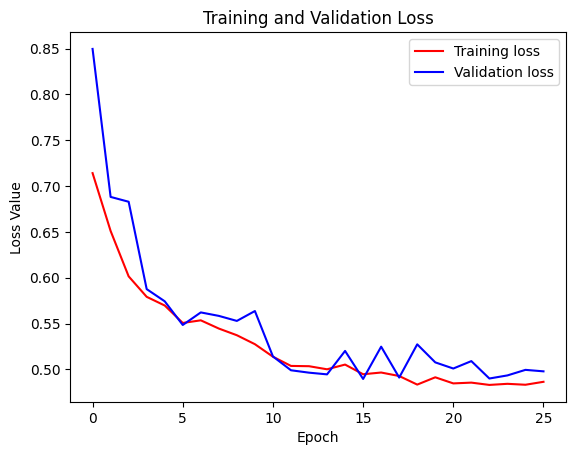

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

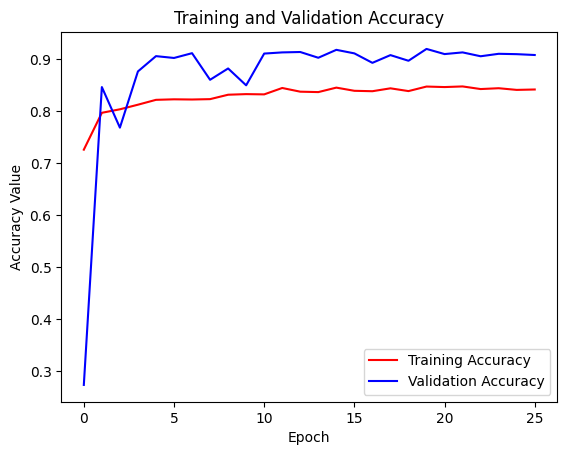

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(history.epoch, accuracy, 'r', label='Training Accuracy')
plt.plot(history.epoch, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

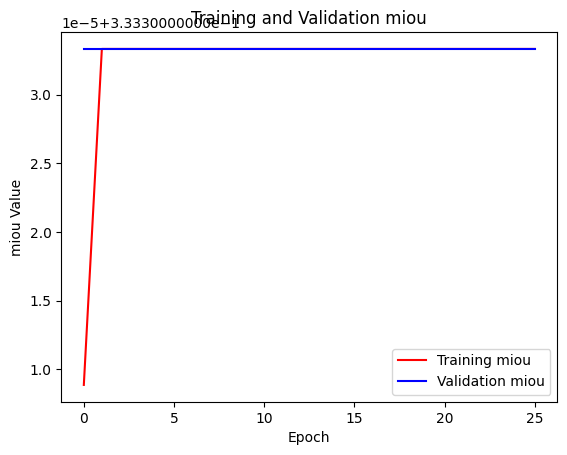

In [48]:
miou = history.history['mean_io_u']
val_miou = history.history['val_mean_io_u']

plt.figure()
plt.plot(history.epoch, miou, 'r', label='Training miou')
plt.plot(history.epoch, val_miou, 'b', label='Validation miou')
plt.title('Training and Validation miou')
plt.xlabel('Epoch')
plt.ylabel('miou Value')
plt.legend()
plt.show()

## Model Prediction

In [51]:
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/test_input/input_data

In [52]:
# move input images to the folder

org_test_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/test/images/'
new_test_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/test_input/input_data'


input_img_paths = []

for dirname, _, filenames in os.walk(org_test_input):
    for filename in filenames:
        input_img_paths.append(os.path.join(dirname, filename))

input_img_paths = sorted(input_img_paths)

random.Random(23).shuffle(input_img_paths)
    
input_img_paths[0:2]

['/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/test/images/bloomington5.tif',
 '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/test/images/innsbruck13.tif']

In [53]:
for file in input_img_paths[::5]:
    shutil.copy(file, new_test_input)

In [55]:
# load the filename in the directory

def read_file(directory):
    blind_test = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            blind_test.append(os.path.join(dirname, filename))
            blind_test = sorted(blind_test)
            return blind_test



In [56]:
# no patch
directory_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/test_input/input_data'
test_input_dir = read_file(directory_input)
print(test_input_dir)

def build_dataset(dir_list, img_size, normalized=True):
    num_imgs = len(dir_list)

    test_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
    image_namelist=[]
    for i in range(len(dir_list)):
        test_imgs[i] = img_to_array(load_img(dir_list[i], target_size=img_size))
        image_name = os.path.basename(dir_list[i])
        image_namelist.append(image_name)

        if normalized==True:
          test_imgs[i] = test_imgs[i]/255.0
    print(image_namelist)
    return test_imgs

img_size = (512,512)

['/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/test_input/input_data/bloomington16.tif']


In [58]:
## load model 
from tensorflow.keras import models

model_file = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/VGG19_24May2023_2.h5'
nopatch_bl_model = models.load_model(model_file, compile=False)
nopatch_bl_model.summary()

model_file = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint/model_vgg19_no_patch_checkpoint.h5'
nopatch_model = models.load_model(model_file, compile=False)
nopatch_model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [74]:
# test_input = build_dataset(test_input_dir[::5], img_size, patch=False)
# print("Shape of val input data:", test_input.shape)

test_input = build_dataset(test_input_dir[::5], img_size)
print("Shape of test input data:", test_input.shape)

['bloomington16.tif']
Shape of test input data: (1, 512, 512, 3)


In [93]:
test_input[0].shape

(512, 512, 3)

In [94]:
num_images = test_input.shape[0]

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images*5))

# for i in range(num_images):
#     # Plot the original image
#     axes[i, 0].imshow(test_input[0]/255.0)
#     axes[i, 0].set_title('Original Image')

    # Predict the image
predicted_image = nopatch_model.predict(np.expand_dims(test_input[0]/255.0, axis=0))[0]

    # Plot the predicted image
axes[0, 1].imshow(predicted_image, cmap='gray')
axes[0, 1].set_title('Predicted Image')

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 944ms/step


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed